After watching Jeremy classify images of bears in the second chapter of [fast.ai](https://course.fast.ai/Lessons/lesson2.html) Practical Deep Learning course, I found myself absent-mindedly consuming content without implementing them. 'Shocked' how pretty easy it is to fall into this trap! 
I searched for simple problems outside the course where I could use his solutions and this one felt like a good stepping stone to delve into. This notebook is an attempt to use the fastai library for image classifcation tasks.

The first step is to ensure that I have the latest instance of fastai available for the code to run.

In [1]:
!pip install -Uqq fastai
from fastai.vision.all import *
from fastai.vision.widgets import *


The input data in this problem is stored as follows:

rock-paper-scissors.
    --> train     
         --> rock *images* |
|                     |               |--> paper |     *images*  |
|                     |               |--> scissors |  *images*  |
|                     |--> test       |--> rock |      *images* |
|                     |                |--> paper |     *images* |
|                     |                |--> scissors |  *images* |                    
|                     |--> validation |*images* |

Hence we establish a path object to access the train dataset first. I use fastai's **get_image_files()** to get all the images under all subdirectories in this path. Following Jeremy's advice I try to use the model to help clean the dataset if possible, hence skipping the training and validation split from the input.

In [2]:
path = Path("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train")
fns = get_image_files(path)
fns

(#2520) [Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper06-050.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper02-044.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper04-056.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper02-048.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper06-081.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper06-051.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper03-029.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper07-045.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper01-109.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper03-090.png')...]

Now that we have some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called DataLoaders. fastai has an extremely flexible system called the data block API. With this API you can fully customize every stage of the creation of your DataLoaders. Here is what we need to create a DataLoaders for the dataset that we just downloaded:

In [3]:
rps = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = parent_label,
                   splitter  = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=RandomResizedCrop(224, min_scale=0.5),
                   batch_tfms=aug_transforms())


First we provide a tuple where we specify what types we want for the independent and dependent variables:

    blocks=(ImageBlock, CategoryBlock)
The independent variable is the thing we are using to make predictions from, and the dependent variable is our target. In this case, our independent variables are images, and our dependent variables are the categories (rock, paper and scissors) for each image

    get_items=get_image_files
For this DataLoaders our underlying items will be file paths. We have to tell fastai how to get a list of those files. The get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default):

    splitter=RandomSplitter(valid_pct=0.2, seed=42)
In this case, we simply want to split our training and validation sets randomly. However, we would like to have the same training/validation split each time we run this notebook, so we fix the random seed 

    get_y=parent_label
The independent variable is often referred to as x and the dependent variable is often referred to as y. **parent_label** is a function provided by fastai that simply gets the name of the folder a file is in. Because we put each of our images into folders based on the type of action shown, this is going to give us the labels that we need.

    item_tfms=RandomResizedCrop(224, min_scale=0.5),
Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a mini-batch). Item transforms are pieces of code that run on each individual item, whether it be an image, category, or so forth. Here we use **RandomResizedCrop** that randomly selects part of the image, and crop to just that part.

    batch_tfms=aug_transforms()
common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. These are provided with the **aug_transforms** function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter.

This command has given us a DataBlock object. This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [4]:
dls = rps.dataloaders(path)

We now create a learner that loads a pre-trained model *(resnet18 in our example)* and fine tune the last 2 epochs on *our* dataset.

In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(2)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.645603,0.039297,0.013889,03:20


epoch,train_loss,valid_loss,error_rate,time
0,0.071227,0.001061,0.000000,04:47
1,0.040537,0.000728,0.000000,04:43


The model seem to have learnt pretty well, but note that this is all run on the "train" dataset from our input directory.

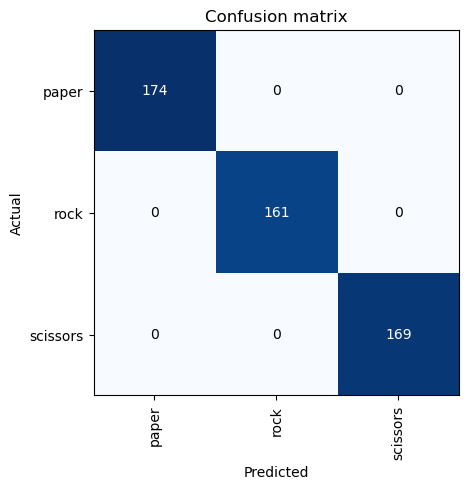

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


Now that the initial run was successful, we try to run the model on our test dataset. Note that fastai provides **GrandparentSplitter** to split the dataset by the folder structure. 

In [7]:
path = Path("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors")

fns = get_image_files(path)

splitter = GrandparentSplitter(train_name='train', valid_name='test')
splits = splitter(fns)
train,test = (fns[i] for i in splits)
train[:3],test[:3]

((#3) [Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper06-050.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper02-044.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/paper04-056.png')],
 (#3) [Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/test/paper/testpaper01-26.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/test/paper/testpaper02-12.png'),Path('/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/test/paper/testpaper01-03.png')])

The split works fine, and we now use this to setup our DataBlock again.

In [8]:
rps = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = parent_label,
                   splitter  = GrandparentSplitter(train_name='train', valid_name='test'),
                   item_tfms=RandomResizedCrop(224, min_scale=0.5),
                   batch_tfms=aug_transforms())

In [9]:
dls = rps.dataloaders(path)
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.523982,0.289103,0.083333,04:05


epoch,train_loss,valid_loss,error_rate,time
0,0.060626,0.184410,0.045699,05:46
1,0.041369,0.317743,0.053763,05:46
2,0.030328,0.052900,0.026882,05:48
3,0.020768,0.026271,0.010753,05:54


The error rate here tapers at around 0.02, so more epochs may not necessarily help in accuracy.

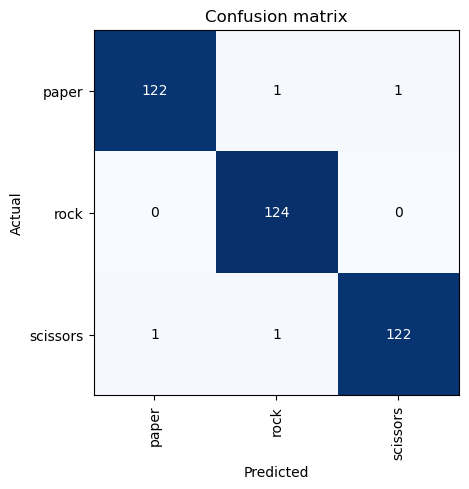

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


fastai has a sweet function to show the exact datasets where the model failed to classify accurately. **plot_top_losses** shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

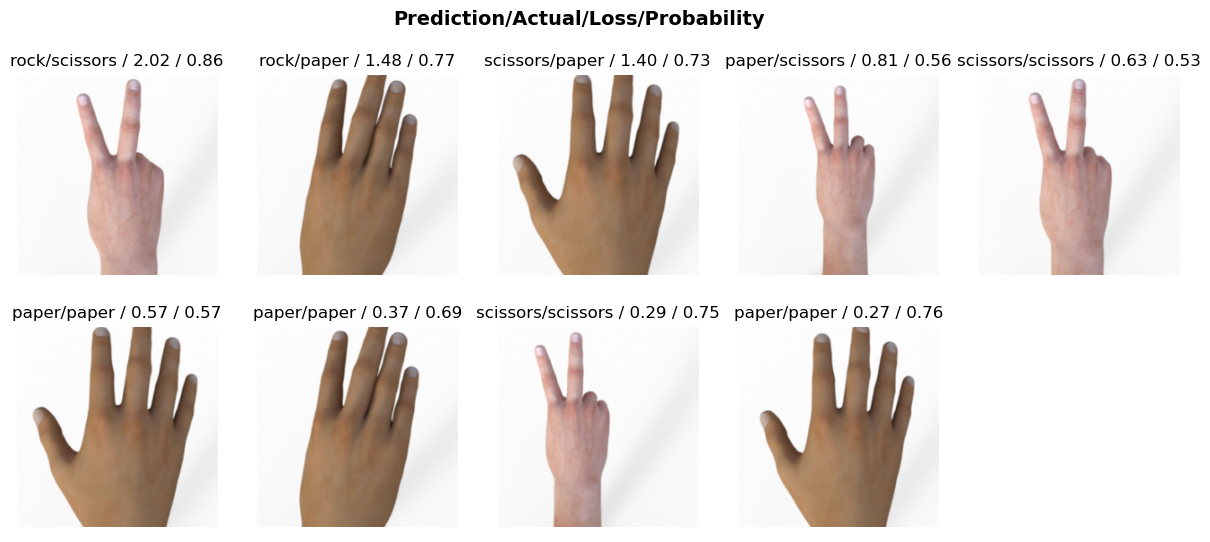

In [11]:
interp.plot_top_losses(9, nrows=2)